In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 24.8 MB/s 
     |████████████████████████████████| 197 kB 37.0 MB/s 
     |████████████████████████████████| 1.2 MB 45.0 MB/s 
     |████████████████████████████████| 60 kB 8.2 MB/s 
Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# From Model to Production

## The Practice of Deep Learning

### Starting Your Project

### The State of Deep Learning

#### Computer vision

#### Text (natural language processing)

#### Combining text and images

#### Tabular data

#### Recommendation systems

#### Other data types

### The Drivetrain Approach

## Gathering Data

# clean
To download images with Bing Image Search, sign up at [Microsoft Azure](https://azure.microsoft.com/en-us/services/cognitive-services/bing-web-search-api/) for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [ ]:
results = search_images_ddg('horse', max_images=100)
len(results), results[0]

(100, 'https://wallup.net/wp-content/uploads/2016/01/58937-horse-animals.jpg')

In [ ]:
dest = 'images/horse.jpg'
download_url(results[0], dest)

Path('images/horse.jpg')

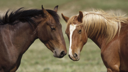

In [ ]:
im = Image.open(dest)
im.to_thumb(128,128)

In [ ]:
bichos_types = 'horse','cow','eagle'
path = Path('bichos')

In [ ]:

if not path.exists():
    path.mkdir()
    
    for o in bichos_types:
        
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} bicho', max_images=100)
        download_images(dest, urls=results)
       

In [ ]:
fns = get_image_files(path)
fns

(#299) [Path('bichos/horse/00000060.jpg'),Path('bichos/horse/00000078.jpeg'),Path('bichos/horse/00000050.jpeg'),Path('bichos/horse/00000085.jpg'),Path('bichos/horse/00000095.jpg'),Path('bichos/horse/00000063.jpg'),Path('bichos/horse/00000076.jpg'),Path('bichos/horse/00000021.jpeg'),Path('bichos/horse/00000069.jpeg'),Path('bichos/horse/00000020.jpg')...]

In [ ]:
failed = verify_images(fns)
failed

(#1) [Path('bichos/cow/00000082.jpg')]

In [ ]:
failed.map(Path.unlink);

### Sidebar: Getting Help in Jupyter Notebooks

### End sidebar

## From Data to DataLoaders

In [ ]:
bichos = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = bichos.dataloaders(path)

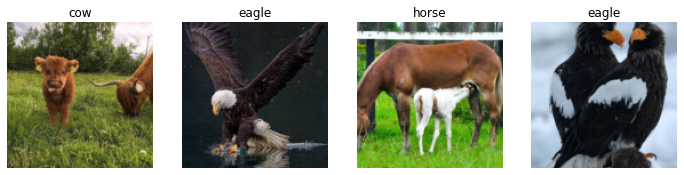

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

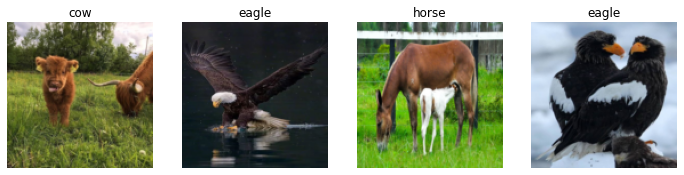

In [ ]:
bichos = bichos.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bichos.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

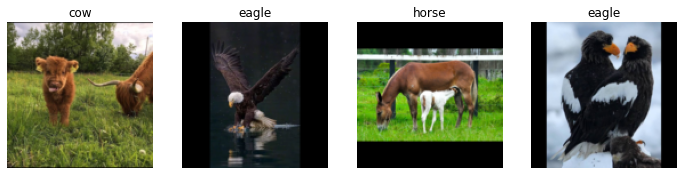

In [ ]:
bichos = bichos.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bichos.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

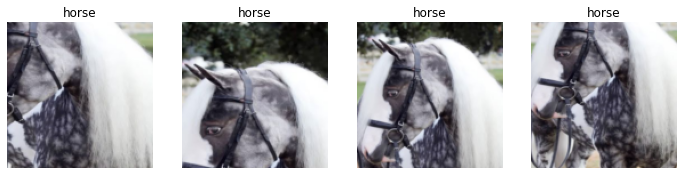

In [ ]:
bichos = bichos.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bichos.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

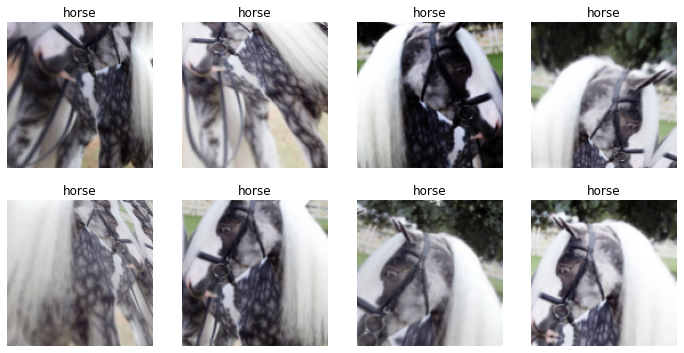

In [ ]:
bichos = bichos.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bichos.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [ ]:
bichos = bichos.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bichos.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.157201,2.529002,0.474576,00:09


epoch,train_loss,valid_loss,error_rate,time
0,1.055677,0.929354,0.338983,00:11
1,0.797034,0.342456,0.118644,00:09
2,0.635503,0.193009,0.067797,00:09
3,0.522484,0.141810,0.050847,00:09


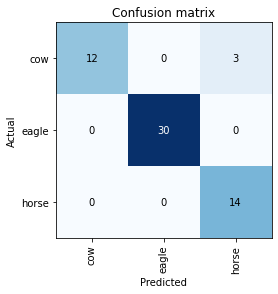

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

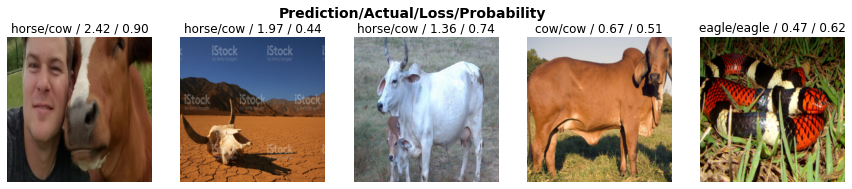

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('images/horse.jpg')

('horse', TensorBase(2), TensorBase([2.2023e-03, 8.1389e-05, 9.9772e-01]))

In [ ]:
learn_inf.dls.vocab

['cow', 'eagle', 'horse']